In [2]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from helpers import bootstrap_CI, correct_for_inflation
import statsmodels.api as sm
import statsmodels.formula.api as smf

# turn off warning
# pd.options.mode.chained_assignment = None

In [3]:
# constants
data_folder = './data/'
MOVIE_PATH = data_folder + 'movie.metadata.tsv'
CHARACTER_PATH = data_folder + 'character.metadata.tsv'
IMDB_MOVIES_PATH = data_folder + 'title.basics.tsv.gz'
RATING_PATH = data_folder + 'title.ratings.tsv'
BUDGET_PATH = data_folder + 'budget.csv'

In [4]:
# create dataframes

# define collumn names
colnames_movies = [
    "wikipedia_movie_ID",
    "freebase_movie_ID",
    "movie_name",
    "movie_release_date",
    "movie_box_office_revenue",
    "movie_runtime",
    "movie_languages",
    "movie_countries",
    "movie_genres",
]

colnames_character = [
    "wikipedia_movie_ID",
    "freebase_movie_ID",
    "last_update",
    "character_name",
    "actor_DOB",
    "actor_gender",
    "actor_height",
    "actor_ethnicity",
    "actor_name",
    "actor_age_at_movie_release",
    "freebase_character/actor_map_ID",
    "freebase_character_ID",
    "freebase_actor_ID",
]


# load data
movies = pd.read_csv(MOVIE_PATH, sep="\t", names=colnames_movies, header=None)
characters = pd.read_csv(
    CHARACTER_PATH, sep="\t", names=colnames_character, header=None
)
budget = pd.read_csv(BUDGET_PATH, usecols=['budget', 'original_title'])
imdb_movies = pd.read_table(IMDB_MOVIES_PATH, sep='\t', usecols=['tconst', 'originalTitle'])
imdb_ratings = pd.read_table(RATING_PATH, sep='\t')

In [5]:
# merge 'movies' with 'budget'
movies = pd.merge(left=movies, right=budget, how='left', left_on='movie_name', right_on='original_title')

# merge 'imdb_movies' with 'imdb_ratings':
imdb_movies = pd.merge(left=imdb_movies, right=imdb_ratings, on='tconst')

# merge 'movies' with 'imdb_movies' + 'imdb_ratings'
movies =pd.merge(left=movies, right=imdb_movies, how='left', left_on='movie_name', right_on='originalTitle')

# include relevant column names
extended_colnames_movies = colnames_movies.copy()
extended_colnames_movies.extend(['budget', 'averageRating', 'numVotes'])
movies = movies[extended_colnames_movies]

In [6]:
movies.head(1)

,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,budget,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",28000000,4.9,55032.0


In [7]:
characters.head(1)

,wikipedia_movie_ID,freebase_movie_ID,last_update,character_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character/actor_map_ID,freebase_character_ID,freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7


In [8]:
movies_budget = movies[~movies["budget"].isna()]
movies_budget = movies_budget[~movies_budget["movie_box_office_revenue"].isna()]

stats.spearmanr(movies_budget["budget"], movies_budget["movie_box_office_revenue"])

SpearmanrResult(correlation=0.3101978333787034, pvalue=0.0)

<AxesSubplot:>

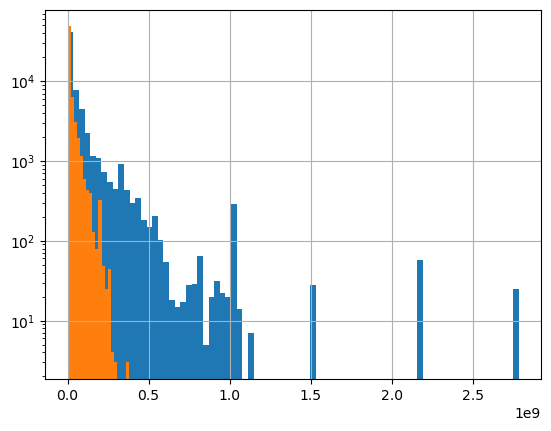

In [27]:
movies_budget['budget'] = pd.to_numeric(movies_budget['budget'])
movies_budget['movie_box_office_revenue'].hist(log=True, bins=80)
movies_budget['budget'].hist(log=True, bins=20)

In [39]:
movies_budget['budget'].idxmax()

67089

In [41]:
movies_budget.loc[67089]

wikipedia_movie_ID                                                   24314116
freebase_movie_ID                                                  /m/09v8clw
movie_name                        Pirates of the Caribbean: On Stranger Tides
movie_release_date                                                 2011-05-07
movie_box_office_revenue                                         1043871802.0
movie_runtime                                                           136.0
movie_languages                            {"/m/02h40lc": "English Language"}
movie_countries                     {"/m/09c7w0": "United States of America"}
movie_genres                {"/m/02qvnvs": "Swashbuckler films", "/m/03k9f...
budget                                                              380000000
averageRating                                                             6.6
numVotes                                                             525990.0
Name: 67089, dtype: object